<a href="https://colab.research.google.com/github/sylvr77/COGS-4230---Human-Machine-Learning-Final-Project/blob/main/HML_Final_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is an implementation of a transformer with multihead attention mechanism from scratch as detailed in a paper that maybe you've heard of : https://arxiv.org/pdf/1706.03762

We decrease complexity in the following ways while meaningfully maintaining the integrity of the architecture:
- Model depth: 2 enc, dec layers instead of 6
- Limited attention heads: 2 attention heads instead of 8
- Smaller embedding size: embedding dim of 64 instead of 512
- Reduced FFN size: feedforward dim of 128 instead of 2048
- Dataset size: about 10 - 15k sentence pairs


# Setup...

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from datasets import load_dataset
import math
import copy
import sentencepiece as spm
import tempfile
import os
import sacrebleu


In [ ]:
# mounting to google drive...
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Making the Transformer Architecture from Scratch...

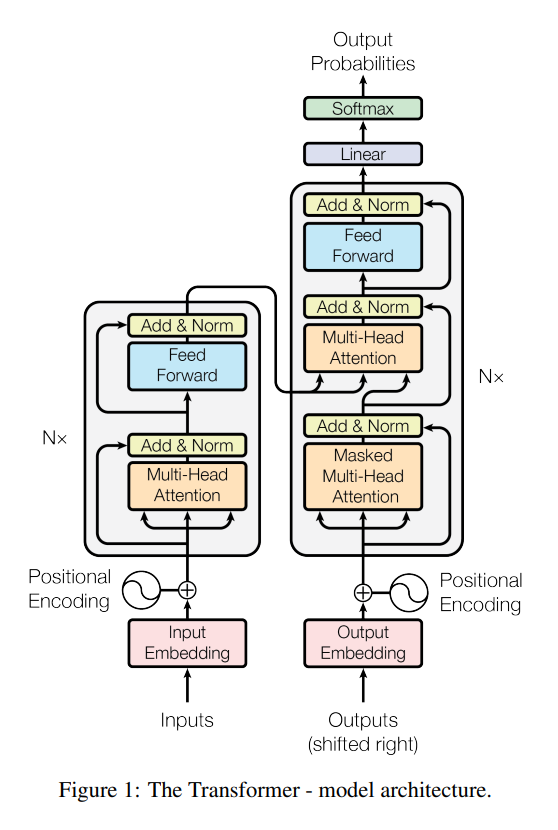

## Multihead Attention Block (Blue)

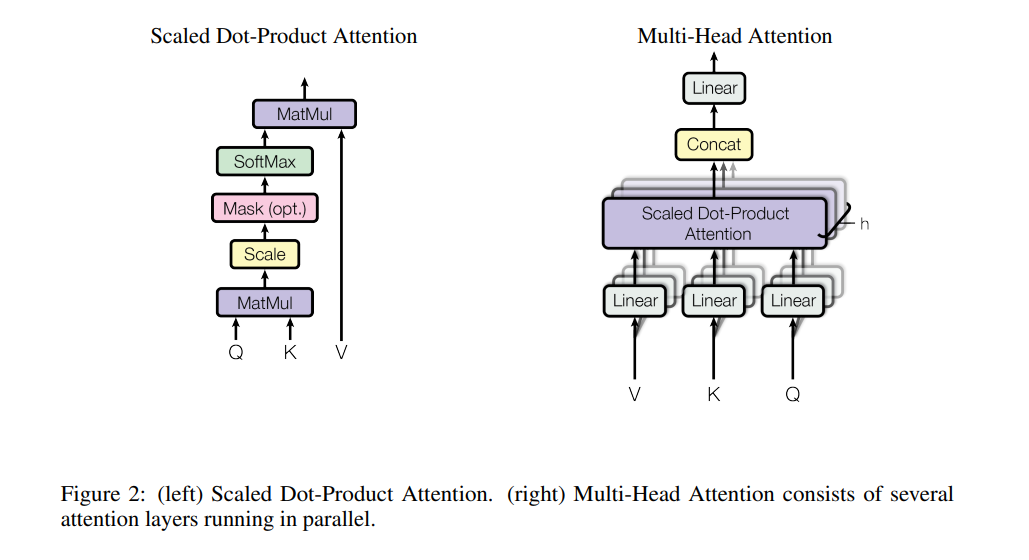

In [ ]:
# implementation of multihead attention as shown in Figure 2 of the paper...
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model = 64, num_heads = 2):
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads


    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    self.d_k = d_model // num_heads


    # initializing the Q, K, V matrices needed for calculating attn...
    #   intuitively, they are all the same dim given the matrix ops required
    #   (transpose, mult, etc)
    self.W_q = nn.Linear(d_model, d_model)
    self.W_k = nn.Linear(d_model, d_model)
    self.W_v = nn.Linear(d_model, d_model)


    # final linear projection after concatenating all heads (after attn)...
    self.W_o = nn.Linear(d_model, d_model)


  # scaled dot product attention mechanism shown in eq (1) of the paper...
  def scaled_dot_product_attention(self, Q, K, V, mask=None):
    # \frac{QK^T}{ \sqrt{d_k} }
    #
    # the reason for the scale factor of \sqrt{d_k} is to counteract gradients
    #   being too small as a result of the softmax of very large dot prod results...
    attnScores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)


    # mask to be used eventually for the decoder...
    if (mask is not None):
      attnScores = attnScores.masked_fill(mask == 0, -1e9)


    # softmax...
    attnProbs = torch.softmax(attnScores, dim=-1)


    # then matrix mult with V...
    output = torch.matmul(attnProbs, V)


    return output


  # we split d_model into num_heads and d_k in order to calculate the MHA as
  #   described by the paper
  def split_heads(self, x):
    batch_size, seq_length, d_model = x.size()

    # "reshape" the input such that we split d_model into num_heads and d_k
    #   then we swap the position of num_heads and seq_length
    return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)


  # can be seen as the "reverse" of split_heads function...
  #   this will be used to concatenate back to the original form, so we "discard"
  #   num_heads
  def combine_heads(self, x):
    batch_size, num_heads, seq_length, d_k = x.size()
    return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)


  # calcultes the MHA as seen in Figure 2 (right)...
  #   we first split heads so that we can calculate attn "separately" on each head
  #   to further understand complex relationships of the input
  #
  #   then we concatenate all the attention scores together into one matrix
  def forward(self, Q, K, V, mask=None):
    # split heads...
    Q = self.split_heads(self.W_q(Q))
    K = self.split_heads(self.W_k(K))
    V = self.split_heads(self.W_v(V))


    # calculating attention for each head separately...
    attn_output = self.scaled_dot_product_attention(Q, K, V, mask)


    # concatenation... (3.2.2 formula of the paper)
    output = self.W_o(self.combine_heads(attn_output))
    return output

## Position-wise FFN Block (Orange)

In [ ]:
# "classic" FFN that contains 2 layers...
#
# called "positionwise" because none of the tokens mix. this is a standard NN,
#   and its significant in obtaining complex transformations of each token's
#   representation via the nonlinear activation function, which in this case,
#   is RELU
class PositionWiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff):
    super(PositionWiseFeedForward, self).__init__()
    self.fc1 = nn.Linear(d_model, d_ff)
    self.fc2 = nn.Linear(d_ff, d_model)
    self.relu = nn.ReLU()


  def forward(self, x):
    return self.fc2(self.relu(self.fc1(x)))

## Positional Encoding

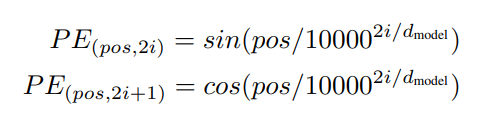

In [ ]:
# used for incorporating the position of each token of the sequence, since the
#   position of words in a sentence impact the meaning
#
# it is through positional encoding that we are able to discard sequential processing
#   and ultimately process the entire input in parallel
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_seq_length):
    super(PositionalEncoding, self).__init__()

    pe = torch.zeros(max_seq_length, d_model)
    position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))


    # all even indices...
    pe[:, 0::2] = torch.sin(position * div_term)

    # all odd indices...
    pe[:, 1::2] = torch.cos(position * div_term)

    self.register_buffer('pe', pe.unsqueeze(0))


  def forward(self, x):
    return x + self.pe[:, :x.size(1)]

## Encoder Block (LHS)

In [ ]:
# implementation of one encoder layer as shown in the LHS of Figure 1...
#   it is very straightforward given the pipeline of input flow
class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = MultiHeadAttention(d_model, num_heads)

    self.feed_forward = PositionWiseFeedForward(d_model, d_ff)

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)

    self.dropout = nn.Dropout(dropout)


  def forward(self, x, mask):
    # calculate MHA...
    attn_output = self.self_attn(x, x, x, mask)

    # add & norm 1...
    x = self.norm1(x + self.dropout(attn_output))

    # FFN...
    ff_output = self.feed_forward(x)

    # add & norm 2...
    x = self.norm2(x + self.dropout(ff_output))

    return x

## Decoder Block (RHS)

In [ ]:
# implementation of one decoder layer as shown in the RHS of Figure 1...
#   this is a bit more nuanced as now we have 2 types of attn:
#   (i) masked self attn and (ii) cross attn
#
# (i) is masked because we need the decoder to only process attn on all indices
#   only up until the current index
#
# (ii) is cross attention because it incorporates the encoder outputs as well
#
# the rest of the implementation is straightforward
class DecoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super(DecoderLayer, self).__init__()
    self.self_attn = MultiHeadAttention(d_model, num_heads)
    self.cross_attn = MultiHeadAttention(d_model, num_heads)

    self.feed_forward = PositionWiseFeedForward(d_model, d_ff)

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.norm3 = nn.LayerNorm(d_model)

    self.dropout = nn.Dropout(dropout)


  def forward(self, x, enc_output, src_mask, tgt_mask):
    # calculate masked self attn...
    #   by only being able to look at all tokens up until the current one, it forces
    #   the decoder to predict only using what it would've "seen" / generated already
    attn_output = self.self_attn(x, x, x, tgt_mask)

    # add & norm 1...
    x = self.norm1(x + self.dropout(attn_output))

    # calculate cross attn (incorporates encoder output)...
    #   the Q linear projection is from the decoder, and K,V linear projections
    #   are from the encoder output.
    #
    # this allows the decoder to predict the next token based on where it should
    #   "look", getting this information from the encoder outputs
    attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)

    # add & norm 2...
    x = self.norm2(x + self.dropout(attn_output))

    # FFN...
    ff_output = self.feed_forward(x)

    # add & norm 3...
    x = self.norm3(x + self.dropout(ff_output))

    return x

## Full Transformer Block

In [ ]:
class Transformer(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
    super(Transformer, self).__init__()
    self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
    self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
    self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

    self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
    self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    self.fc = nn.Linear(d_model, tgt_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def generate_mask(self, src, tgt):
    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
    tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
    seq_length = tgt.size(1)
    nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
    tgt_mask = tgt_mask & nopeak_mask
    return src_mask, tgt_mask

  def forward(self, src, tgt):
    src_mask, tgt_mask = self.generate_mask(src, tgt)
    src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
    tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

    enc_output = src_embedded
    for enc_layer in self.encoder_layers:
      enc_output = enc_layer(enc_output, src_mask)

    dec_output = tgt_embedded
    for dec_layer in self.decoder_layers:
      dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

    output = self.fc(dec_output)
    return output

# Preprocessing Data...

In [ ]:
if False:
  src_vocab_size = 5000
  tgt_vocab_size = 5000
  d_model = 512
  num_heads = 8
  num_layers = 6
  d_ff = 2048
  max_seq_length = 100
  dropout = 0.1

else:
  src_vocab_size = 2500
  tgt_vocab_size = 2500
  d_model = 64
  num_heads = 2
  num_layers = 2
  d_ff = 128
  max_seq_length = 100
  dropout = 0.1


model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)


if False:
  # Generate random sample data
  src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
  tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
else:
  pass

In [ ]:
# the dataset that i have chosen to use is from tatoeba
dataset = load_dataset("Verah/tatoeba_dedupe_en-jp_2024-March-01", split="train")

for i in range(5):
  print(dataset[i])

{'id': 1, 'english': 'While in England I often consulted the guidebook.', 'japanese': 'イギリスにいる間、私はよくそのガイドブックを参考にした。'}
{'id': 2, 'english': 'Look at the sports car over there.', 'japanese': 'あそこのスポーツカーを見なさい。'}
{'id': 3, 'english': 'Never did I expect that he would fail the examination.', 'japanese': '彼が試験に失敗するなんて私は予想もしなかった。'}
{'id': 4, 'english': 'He knows no foreign language except English.', 'japanese': '彼は英語以外の外国語は全く知らない。'}
{'id': 5, 'english': 'All their secrets have been revealed.', 'japanese': '彼らの秘密が全部暴かれた。'}


In [ ]:
# going from en --> jp sentences for my machine translation task...

allSrcSen = [i["english"] for i in dataset]
allTgtSen = [i["japanese"] for i in dataset]

In [ ]:
len(allSrcSen)

201607

In [ ]:
# only want to select a subset of the dataset...
srcSen = allSrcSen[:10000]
tgtSen = allTgtSen[:10000]

In [ ]:
# "basic" / standard token IDs...
PAD_ID = 0
BOS_ID = 1
EOS_ID = 2
UNK_ID = 3

# transformer is auto regressive meaning it predicts future values based on values its already computed (linear combination)...
#  the implication of this is that the decoder which is supposed ot predict the sentence wont actually start gneerating until we tell it to
#  and additionally, it wont stop generating until we tell it to

#  thus we need to encode the bos and eos for beginning and end of sequence tokens

bpe stands for byte pair encoding

for tokenization, going by words isnt ideal since languages like japanese and chinese dont use spaces.

going by character for these languages may result in long sequences since multiple characters make up a word in these languages such as 呉越同舟


solution:
do BPE which is byte pair encoding. this works for both english and japanese

for bpe, tokens are not predefined. they are not words, nor are they characters

given the datasets, it tokenizes based on the most frequent adjacent characters in the text. this needs to be learned by the tokenization model

In [ ]:
def train_spm(sentences, model_prefix, vocab_size=2000):
    """
    Train a BPE tokenizer using SentencePiece.
    """

    # Write sentences to a temporary file
    with tempfile.NamedTemporaryFile("w", delete=False, encoding="utf-8") as f:
        for s in sentences:
            f.write(s.replace("\n", " ") + "\n")
        input_path = f.name

    # Train BPE model
    spm.SentencePieceTrainer.train(
        input=input_path,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        model_type="bpe",
        character_coverage=1.0,  # crucial for Japanese
        pad_id=PAD_ID,
        bos_id=BOS_ID,
        eos_id=EOS_ID,
        unk_id=UNK_ID
    )

    os.remove(input_path)


In [ ]:
# Train on your 1k subset
train_spm(srcSen, model_prefix="spm_en", vocab_size=2500)
train_spm(tgtSen, model_prefix="spm_jp", vocab_size=2500)

# Load trained tokenizers
sp_en = spm.SentencePieceProcessor(model_file="spm_en.model")
sp_jp = spm.SentencePieceProcessor(model_file="spm_jp.model")


In [ ]:
# Pick one example
en_sentence = srcSen[0]
jp_sentence = tgtSen[0]

# Encode
src_ids = sp_en.encode(en_sentence, out_type=int)
tgt_ids = sp_jp.encode(jp_sentence, out_type=int)

print("EN sentence:", en_sentence)
print("EN ids:", src_ids)

print("\nJP sentence:", jp_sentence)
print("JP ids:", tgt_ids)


EN sentence: While in England I often consulted the guidebook.
EN ids: [61, 262, 53, 43, 2030, 14, 768, 686, 437, 28, 13, 737, 362, 2214, 2429]

JP sentence: イギリスにいる間、私はよくそのガイドブックを参考にした。
JP ids: [406, 483, 776, 463, 448, 412, 9, 480, 426, 135, 133, 15, 765, 483, 514, 608, 249, 416, 1184, 583, 412, 8, 407]


In [ ]:
# Add BOS / EOS (important for Transformer)
src_ids = src_ids + [EOS_ID]
tgt_ids = [BOS_ID] + tgt_ids + [EOS_ID]

print("\nFinal source ids:", src_ids)
print("Final target ids:", tgt_ids)



Final source ids: [61, 262, 53, 43, 2030, 14, 768, 686, 437, 28, 13, 737, 362, 2214, 2429, 2]
Final target ids: [1, 406, 483, 776, 463, 448, 412, 9, 480, 426, 135, 133, 15, 765, 483, 514, 608, 249, 416, 1184, 583, 412, 8, 407, 2]


In [ ]:
# Decode back (sanity check)
print("\nDecoded JP:", sp_jp.decode(tgt_ids[1:-1]))



Decoded JP: イギリスにいる間、私はよくそのガイドブックを参考にした。


In [ ]:
# sanity checking...
print("EN vocab:", sp_en.get_piece_size())
print("JP vocab:", sp_jp.get_piece_size())

print("EN pieces:", sp_en.id_to_piece(0), sp_en.id_to_piece(1), sp_en.id_to_piece(2), sp_en.id_to_piece(3))
print("JP pieces:", sp_jp.id_to_piece(0), sp_jp.id_to_piece(1), sp_jp.id_to_piece(2), sp_jp.id_to_piece(3))


EN vocab: 2500
JP vocab: 2500
EN pieces: <pad> <s> </s> <unk>
JP pieces: <pad> <s> </s> <unk>


embedding vectror size --> each token gets an embedding vector of that size for that token's representation

In [ ]:
# src sentences need EOS to tell transformer where the sentence ends
# tgt sentences need both BOS and EOS to tell transformer when to start and end generation
PAD_ID, BOS_ID, EOS_ID = 0, 1, 2
MAX_LEN = 64  # keep small while debugging

def encode_pair(en, jp):
    src = sp_en.encode(en, out_type=int)[:MAX_LEN-1] + [EOS_ID]
    tgt = [BOS_ID] + sp_jp.encode(jp, out_type=int)[:MAX_LEN-2] + [EOS_ID]
    return src, tgt


# zip (en_j, jp_i)
pairs = [encode_pair(en, jp) for en, jp in zip(srcSen, tgtSen)]


In [ ]:
# for batch_i, we must pad all sentences to be max(length of sentence_i) in batch_i, so that its all consistnet

# dataloader is a way of batching the training data. and we can defined that as seen fit

import torch
from torch.utils.data import Dataset, DataLoader

def pad_1d(seqs, pad_id=PAD_ID):
    max_len = max(len(s) for s in seqs)
    out = torch.full((len(seqs), max_len), pad_id, dtype=torch.long)
    for i, s in enumerate(seqs):
        out[i, :len(s)] = torch.tensor(s, dtype=torch.long)
    return out

class PairDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        return self.pairs[idx]

def collate(batch):
    srcs, tgts = zip(*batch)
    return pad_1d(srcs), pad_1d(tgts)

loader = DataLoader(PairDataset(pairs), batch_size=16, shuffle=True, collate_fn=collate)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

src_batch, tgt_batch = next(iter(loader))
src_batch = src_batch.to(device)
tgt_batch = tgt_batch.to(device)

out = model(src_batch, tgt_batch)  # uses your internal generate_mask
print("src:", src_batch.shape)
print("tgt:", tgt_batch.shape)
print("out:", out.shape)


src: torch.Size([16, 29])
tgt: torch.Size([16, 28])
out: torch.Size([16, 28, 2500])


In [ ]:
# ----------------------------
# Loss + optimizer
# ----------------------------
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.98), eps=1e-9)

# ----------------------------
# Training loop (teacher forcing)
# ----------------------------
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    total_tokens = 0

    for src, tgt in loader:
        src = src.to(device)  # (B, S)
        tgt = tgt.to(device)  # (B, T_full)

        # Teacher forcing shift:
        # decoder input excludes final token
        # labels exclude first token (BOS)
        tgt_in  = tgt[:, :-1]   # (B, T)
        tgt_out = tgt[:,  1:]   # (B, T)

        optimizer.zero_grad(set_to_none=True)

        # logits: (B, T, V)
        logits = model(src, tgt_in)

        B, T, V = logits.shape

        # Cross-entropy over all positions, ignoring PAD labels
        loss = criterion(
            logits.reshape(B*T, V),
            tgt_out.reshape(B*T)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Token-weighted loss tracking (ignore PAD positions)
        nonpad = (tgt_out != PAD_ID).sum().item()
        total_loss += loss.item() * nonpad
        total_tokens += nonpad

    return total_loss / max(total_tokens, 1)

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    for src, tgt in loader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_in  = tgt[:, :-1]
        tgt_out = tgt[:,  1:]

        logits = model(src, tgt_in)
        B, T, V = logits.shape

        loss = criterion(
            logits.reshape(B*T, V),
            tgt_out.reshape(B*T)
        )

        nonpad = (tgt_out != PAD_ID).sum().item()
        total_loss += loss.item() * nonpad
        total_tokens += nonpad

    return total_loss / max(total_tokens, 1)

# ----------------------------
# Run training
# ----------------------------
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, loader)
    val_loss = eval_one_epoch(model, loader)  # using same loader for now (you can split later)
    print(f"Epoch {epoch:02d} | train loss/token: {train_loss:.4f} | val loss/token: {val_loss:.4f}")

Epoch 01 | train loss/token: 5.8631 | val loss/token: 5.3783
Epoch 02 | train loss/token: 5.3089 | val loss/token: 5.1316
Epoch 03 | train loss/token: 5.0985 | val loss/token: 4.9180
Epoch 04 | train loss/token: 4.9229 | val loss/token: 4.7350
Epoch 05 | train loss/token: 4.7641 | val loss/token: 4.5664
Epoch 06 | train loss/token: 4.6237 | val loss/token: 4.4180
Epoch 07 | train loss/token: 4.5022 | val loss/token: 4.2868
Epoch 08 | train loss/token: 4.3942 | val loss/token: 4.1835
Epoch 09 | train loss/token: 4.3007 | val loss/token: 4.0801
Epoch 10 | train loss/token: 4.2209 | val loss/token: 3.9978


In [ ]:
@torch.no_grad()
def translate_greedy(model, sp_src, sp_tgt, sentence_en, max_len=64, device="cpu"):
    model.eval()

    # Encode source + EOS
    src_ids = sp_src.encode(sentence_en, out_type=int)[:max_len-1] + [EOS_ID]
    src = torch.tensor(src_ids, dtype=torch.long, device=device).unsqueeze(0)  # (1, S)

    # Start decoder with BOS
    tgt = torch.tensor([[BOS_ID]], dtype=torch.long, device=device)  # (1, 1)

    for _ in range(max_len - 1):
        logits = model(src, tgt)                 # (1, T, V)
        next_id = int(logits[0, -1].argmax())    # take best token at last step

        tgt = torch.cat([tgt, torch.tensor([[next_id]], device=device)], dim=1)

        if next_id == EOS_ID:
            break

    # Remove BOS and everything after EOS
    out_ids = tgt[0].tolist()
    if EOS_ID in out_ids:
        out_ids = out_ids[1:out_ids.index(EOS_ID)]
    else:
        out_ids = out_ids[1:]

    return sp_tgt.decode(out_ids)



In [ ]:
# pip install sacrebleu
import random

def bleu_score(model, sp_src, sp_tgt, src_list, ref_list, n=200, max_len=64):
    idxs = list(range(len(src_list)))
    random.shuffle(idxs)
    idxs = idxs[:n]

    hyps = []
    refs = []
    device = next(model.parameters()).device

    for i in idxs:
        pred = translate_greedy(model, sp_src, sp_tgt, src_list[i], max_len=max_len, device=device)
        hyps.append(pred)
        refs.append(ref_list[i])

    # sacrebleu expects list of reference corpora: [refs]
    bleu = sacrebleu.corpus_bleu(hyps, [refs])
    return bleu.score



In [ ]:
device = next(model.parameters()).device

for i in [0, 1, 2, 3, 4]:
    en = srcSen[i]
    jp_true = tgtSen[i]
    jp_pred = translate_greedy(model, sp_en, sp_jp, en, max_len=64, device=device)

    print("Source (EN):", en)
    print("Predicted (JP):", jp_pred)
    print("True (JP):", jp_true)
    print("-" * 75)

print("BLEU Score:", bleu_score(model, sp_en, sp_jp, srcSen, tgtSen, n=200))


Source (EN): While in England I often consulted the guidebook.
Predicted (JP) 子供たちに、その問題を受けている。
True (JP) イギリスにいる間、私はよくそのガイドブックを参考にした。
---------------------------------------------------------------------------
Source (EN): Look at the sports car over there.
Predicted (JP) まままい。
True (JP) あそこのスポーツカーを見なさい。
---------------------------------------------------------------------------
Source (EN): Never did I expect that he would fail the examination.
Predicted (JP) 彼がその仕事を受けている。
True (JP) 彼が試験に失敗するなんて私は予想もしなかった。
---------------------------------------------------------------------------
Source (EN): He knows no foreign language except English.
Predicted (JP) 彼は英語を着ていた。
True (JP) 彼は英語以外の外国語は全く知らない。
---------------------------------------------------------------------------
Source (EN): All their secrets have been revealed.
Predicted (JP) もしれないが、その問題を受けている。
True (JP) 彼らの秘密が全部暴かれた。
---------------------------------------------------------------------------
BLEU Score: 0.0
